In [1]:
%pip install --quiet -U pip -r ../requirements/requirements-training.txt ../.

Note: you may need to restart the kernel to use updated packages.


In [35]:
import jax
import pickle
import jax.numpy as jnp
import warnings
warnings.filterwarnings("ignore")

from jumanji.training.train import train
from jumanji.training.setup_train import setup_agent, setup_env
from jumanji.training.utils import first_from_device
from hydra import compose, initialize

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.isinteractive()

True

In [36]:
with initialize(version_base=None, config_path="../jumanji/training/configs"):
    cfg = compose(config_name="config.yaml")
cfg

{'agent': 'a2c', 'seed': 0, 'logger': {'type': 'neptune', 'name': '${agent}_${env.name}_clem_gpu_lr_3e-4_gamma_0.99_padding_valid_norm_adv_True', 'save_checkpoint': True}, 'env': {'name': 'maze', 'env_kwargs': {'n_rows': 10, 'n_cols': 10}, 'network': {'num_channels': [32, 32, 8], 'policy_layers': [64, 64], 'value_layers': [128, 128]}, 'training': {'num_epochs': 100, 'num_learner_steps_per_epoch': 500, 'n_steps': 10, 'total_batch_size': 128}, 'evaluation': {'eval_total_batch_size': 500, 'greedy_eval_total_batch_size': 500}, 'a2c': {'normalize_advantage': True, 'discount_factor': 0.99, 'bootstrapping_factor': 0.95, 'l_pg': 1.0, 'l_td': 1.0, 'l_en': 0.01, 'learning_rate': 0.0003}}}

In [38]:
with open("training_state.pickle","rb") as f:
    training_state = pickle.load(f)

params = first_from_device(training_state.params_state.params)
env = setup_env(cfg).unwrapped
agent = setup_agent(cfg, env)
policy = agent.make_policy(params.actor, stochastic = False)

In [39]:
states = []
actions = {0:"Up", 1:"Right", 2:"Down", 3:"Left"}

key = jax.random.PRNGKey(cfg.seed)
for trial in range(10):
    key, reset_key = jax.random.split(key) 
    state, timestep = env.reset(reset_key)
    while not timestep.last():
        key, action_key = jax.random.split(key) 
        action, _ = policy(jax.tree_util.tree_map(lambda x: jnp.expand_dims(x, axis=0), timestep.observation), action_key)
        # print(timestep.observation.agent_position, actions[action.item()])
        state, timestep = env.step(state, action.item())
        states.append(state)


In [42]:
env.animate(states, path="./maze.gif", interval=150)

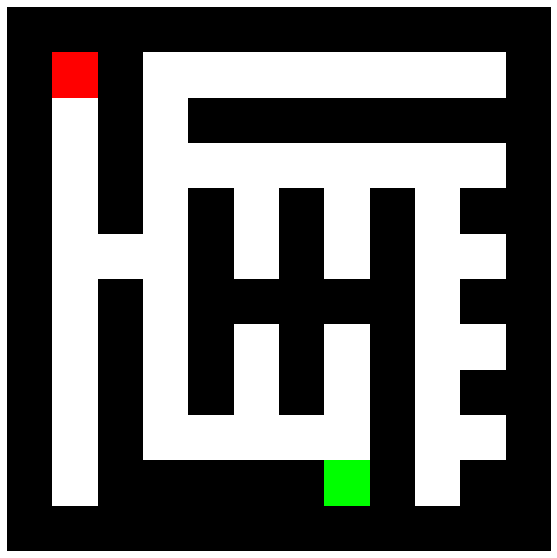

In [61]:
env.render(state[0])